In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pickle

import matplotlib.pyplot as plt
from ase.build.tools import sort
from ase.visualize import plot
from mp_api.client import MPRester  # new version of Materials Project API
from pymatgen.io.ase import AseAtomsAdaptor

from mcmc.utils.slab import surface_from_bulk

/home/dux/miniforge3/envs/vssr-mc/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
MP_API_KEY = os.environ.get(
    "MP_API_KEY",
    os.environ.get("MP_API_KEY"),  # replace with your own API key
)  # new Materials Project website

CHEM_FORMULA = "SrTiO3"

Find SrTiO3 bulk in [Materials Project](https://next-gen.materialsproject.org)

In [4]:
mp_id = "mp-5229"  # cubic SrTiO3
properties = [
    "energy",
    "spacegroup",
    "structure",
    "cif",
    "formation_energy_per_atom",
    "e_above_hull",
    "band_gap",
    "material_id",
    "tags",
]

with MPRester(MP_API_KEY) as mpr:
    mp_data = mpr.materials.search(
        material_ids=[mp_id],
        fields=properties,
    )[0]

Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 5924.16it/s]


Visualize the unit cell

In [5]:
# Convert object to ASE Atoms object
ase_adaptor = AseAtomsAdaptor()
SrTiO3_unit_cell = ase_adaptor.get_atoms(mp_data.structure)

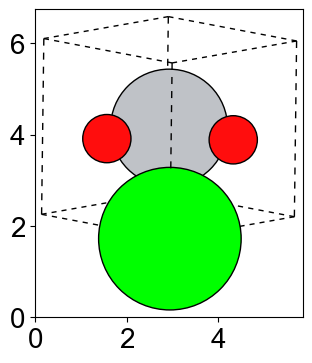

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=100)
plot.plot_atoms(SrTiO3_unit_cell, ax, radii=0.8, rotation=("-75x, 45y, 10z"))
plt.show()

Create a 2x2x2 supercell that we can use to construct the surface

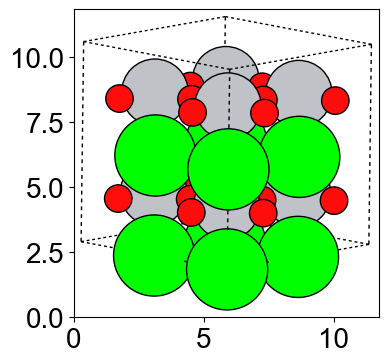

In [7]:
SrTiO3_2x2x2_cell = SrTiO3_unit_cell.repeat((2, 2, 2))
fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=100)
plot.plot_atoms(SrTiO3_2x2x2_cell, ax, radii=0.8, rotation=("-75x, 45y, 10z"))
plt.show()

Cut the (001) surface slab

In [8]:
miller_index = (0, 0, 1)
fixed = 0  # doesn't matter for now
layers = 15  # in Angstroms
size = [2, 2]
vacuum = 7.5  # on each size
symmetrize = False
iterm = 1  # ensure Ti atoms are on the surface

# Use pristine bulk to create surface
SrTiO3_001_2x2_slab, surf_atoms = surface_from_bulk(
    SrTiO3_2x2x2_cell,
    miller_index,
    layers=layers,
    fixed=fixed,
    size=size,
    vacuum=vacuum,
    iterm=iterm,
)

# Set surface atoms
SrTiO3_001_2x2_slab.set_surface_atoms(surf_atoms)

# Sort atoms by increasing z-coordinate
SrTiO3_001_2x2_slab = sort(SrTiO3_001_2x2_slab, tags=SrTiO3_001_2x2_slab.positions[:, 2])

print(f"Surface atoms are {SrTiO3_001_2x2_slab.get_surface_atoms()}")
print(f"Tags are {SrTiO3_001_2x2_slab.get_tags()}")
print(f"Positions are {SrTiO3_001_2x2_slab.get_positions()}")

Surface atoms are [68 69 70 71 72 73 74 75 76 77 78 79]
Tags are [8 8 8 8 8 8 8 8 7 7 7 7 7 7 7 7 7 7 7 7 6 6 6 6 6 6 6 6 5 5 5 5 5 5 5 5 5
 5 5 5 4 4 4 4 4 4 4 4 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 1 1 1 1 1 1
 1 1 1 1 1 1]
Positions are [[ 0.          0.          7.5       ]
 [ 1.95635065  1.95635066  7.5       ]
 [ 0.          3.91270131  7.5       ]
 [ 1.95635065  5.86905197  7.5       ]
 [ 3.91270131  0.          7.5       ]
 [ 5.86905196  1.95635066  7.5       ]
 [ 3.91270131  3.91270131  7.5       ]
 [ 5.86905196  5.86905197  7.5       ]
 [ 0.          0.          9.45635066]
 [ 1.95635065  0.          9.45635066]
 [ 0.          1.95635066  9.45635066]
 [ 0.          3.91270131  9.45635066]
 [ 1.95635065  3.91270131  9.45635066]
 [ 0.          5.86905197  9.45635066]
 [ 3.91270131  0.          9.45635066]
 [ 5.86905196  0.          9.45635066]
 [ 3.91270131  1.95635066  9.45635066]
 [ 3.91270131  3.91270131  9.45635066]
 [ 5.86905196  3.91270131  9.45635066]
 [ 3.91270131  5

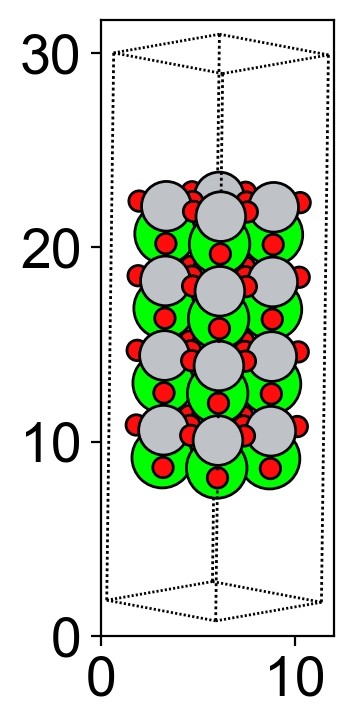

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=200)
plot.plot_atoms(SrTiO3_001_2x2_slab, ax, radii=0.8, rotation=("-75x, 45y, 10z"))
plt.show()

Save our surface slab

In [10]:
# save the surface
with open(f"data/SrTiO3_001/{CHEM_FORMULA}_001_2x2x4_pristine_slab.pkl", "wb") as f:
    pickle.dump(SrTiO3_001_2x2_slab, f)